# Here we'll train some models!

# Imports and Project Configuration

This cell sets up the notebook environment and loads configuration details required throughout the project.

### What this cell does
- Imports standard and third-party libraries for:
  - Data handling: `pandas`, `numpy`
  - Modeling: `sklearn` (pipelines, preprocessing, linear models, metrics)
  - Visualization: `matplotlib`
  - Configuration parsing: `yaml`
- Loads project configuration files from the `conf/` directory:
  - `config.yaml` – overall project paths and settings
  - `variable_types.yaml` – defines column groups and data types
  - `cleaning_rules.yaml` – data cleaning and transformation rules
- Defines key directories and variables:
  - `PROJ`, `RAW_DIR`, `PROC_DIR` – base project paths
  - `numeric_cols` – list of numeric feature columns
- Ensures custom modules in `pipeline/` (for example, `AutoTransform`, `Winsorizer`) are importable.
- Silences `pandas` performance warnings for cleaner notebook output.

### Notes
- Paths are resolved relative to this notebook’s parent directory, so run this from within the `notebooks/` directory.

In [ ]:
from __future__ import annotations
import pathlib
import sys
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNetCV, Lasso, LassoCV, LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
    learning_curve
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Project root and config files
PROJ = pathlib.Path().resolve().parent
CFG = yaml.safe_load(open(PROJ / "conf" / "config.yaml"))

# Variable types (numeric/categorical, etc.)
var_types = yaml.safe_load(open(PROJ / "conf" / "variable_types.yaml"))

# Data directories from config
RAW_DIR = PROJ / CFG["data"]["raw_dir"]
PROC_DIR = PROJ / CFG["data"]["processed_dir"]

# Convenience handle for numeric columns from variable types
numeric_cols = var_types["numeric_variables"]

# Cleaning rules
RULES = yaml.safe_load(open(PROJ / "conf" / "cleaning_rules.yaml"))

# Make project importable (so `pipeline.*` works)
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))

# Local project transformers (requires PROJ on sys.path above)
from pipeline.transformers import AutoTransform, Winsorizer  # noqa: E402


# Warnings / display setup
PerfWarn = pd.errors.PerformanceWarning
warnings.filterwarnings("ignore", category=PerfWarn)

# Data Loading and Train/Validation/Test Split

This cell loads the preprocessed CBECS dataset and prepares the modeling splits.

### What this cell does
- Reads the cleaned data file `cbecs_2018_clean.parquet` from the processed data directory defined in the configuration.
- Derives lists of categorical and numeric feature columns from `variable_types.yaml`, restricted to those present in the loaded DataFrame.
- Converts all categorical columns to `object` type to ensure consistent downstream handling by `sklearn` preprocessing steps.
- Defines features `X` and target variable `y` (`LOG_MFBTU` is the logged energy-use target).
- Performs an **80/10/10 split**:
  - 10% reserved for final test evaluation (`X_test`, `y_test`)
  - Remaining 90% split again into 10% validation and 80% training (`X_train`, `y_train`, `X_val`, `y_val`)
- Uses a fixed random seed (`rand = 1`) for reproducibility.
- Verifies that the splits collectively cover all rows in the dataset.

In [21]:
# First read in the file...
df = pd.read_parquet(PROC_DIR / "cbecs_2018_clean.parquet")  # load preprocessed data
cat_cols = [c for c in var_types["categorical_variables"] if c in df.columns]  # categorical cols present in df
num_cols = [c for c in var_types["numeric_variables"] if c in df.columns]      # numeric cols present in df

# Coerce all non-numeric columns to be astype object. Many are actually integers that refer to codes.
df[cat_cols] = df[cat_cols].astype(object)  # ensure consistent dtype for downstream encoders (e.g., OneHotEncoder)

# Assign X, y 
X = df.drop('LOG_MFBTU', axis=1)  # feature matrix (all columns except target)
y = df['LOG_MFBTU']               # target on log scale (assumed created upstream)

# Split the data into validation, train, and test sets
# e.g., 80/10/10 split
test_size = 0.10  # final hold-out fraction for unbiased evaluation
val_size  = 0.10  # desired validation fraction out of the full dataset
rand      = 1     # fixed seed for reproducibility

# 1) Hold out test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=rand, shuffle=True
)  # split off the test set first

# 2) From the remainder, carve out validation
val_rel = val_size / (1.0 - test_size)  # convert absolute val fraction (10%) into relative share of the remaining 90%
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_rel, random_state=rand, shuffle=True
)  # create validation split from the training pool

# Check and make sure the splits worked as expected...
df.shape  # quick visual confirmation of total rows/columns
check_shape = X_train.shape[0] + X_test.shape[0] + X_val.shape[0] == df.shape[0]  # verify row counts add up

print(f"Split correctly: {check_shape}")  # True indicates the 80/10/10 partitioning sums to full dataset

Split correctly: True


# Baseline Benchmarks for model comparison

I add two deliberately simple benchmarks before training richer models to anchor expectations and prevent overclaiming.

1) Mean predictor (predict `mean(y_train)` for everyone).  
   - Why: This is the irreducible “do nothing” baseline. Any sensible model must beat it on validation/test; otherwise I'm fitting noise or leaking information.  
   - We compute the mean strictly from `y_train` to avoid contaminating evaluation with information not available at fit time.

2) One-feature linear regression on building size (`SQFT_log1p` by default).  
   - Why: Floor area is a first-order driver of energy use; if our pipeline can’t beat “energy ~ size” on held-out data, it’s unlikely to add value in practice. This is a more realistic benchmark than the mean because it encodes a core domain relationship.  
   - This establishes a practical reference that a multivariate model should surpass. It also gives an interpretable slope and intercept that help validate directionality and scaling.  

General notes:
- We evaluate on validation/test to avoid optimistic bias.  
- We report R², SSE, and MSE because they reveal different aspects: explanation power (R²), total squared error mass (SSE) for scale/context, and average error (MSE) for comparability.  
- If the one-feature model strongly outperforms the mean but the full model does not outperform the one-feature baseline, I likely have either over-regularization, noisy engineered features diluting signal, or preprocessing mismatches.

In [ ]:
from __future__ import annotations
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def baseline_with_sqft(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    feature="num__SQFT_log1p",
    print_lines=True,
    decimals=4,
):
    """
    Baselines:
      1) Predict mean(y_train)
      2) One-feature OLS using `feature`
    """

    # targets: 1D arrays; evaluate on test if provided, else train
    y_train = np.asarray(y_train).ravel()
    y_eval = y_train if y_test is None else np.asarray(y_test).ravel()
    n = int(y_eval.shape[0])

    # ---- Baseline 1: mean predictor ----
    yhat_mean_value = float(np.mean(y_train))
    yhat_mean = np.full_like(y_eval, fill_value=yhat_mean_value, dtype=float)
    r2_mean = r2_score(y_eval, yhat_mean)
    resid_mean = y_eval - yhat_mean
    sse_mean = float(np.sum(resid_mean**2))
    mse_mean = float(sse_mean / n)

    mean_results = {
        "yhat_mean": yhat_mean_value,
        "r2": r2_mean,
        "sse": sse_mean,
        "mse": mse_mean,
        "n": n,
    }

    # helper: return a single column as 2D array
    def _col2d(X, feat):
        if isinstance(X, pd.DataFrame):
            if feat not in X.columns:
                raise KeyError(f"Column '{feat}' not found in X.")
            return X[[feat]].to_numpy()          # keep 2D
        X = np.asarray(X)
        if isinstance(feat, (int, np.integer)):
            return X[:, [feat]]                  # keep 2D
        raise TypeError("For ndarray X, 'feature' must be an int; for DataFrame, a column name.")

    # ---- Baseline 2: one-feature LinearRegression ----
    Xtr_col = _col2d(X_train, feature)
    lr = LinearRegression().fit(Xtr_col, y_train)

    Xev_col = Xtr_col if X_test is None else _col2d(X_test, feature)
    yhat_lr = lr.predict(Xev_col)
    r2_lr = r2_score(y_eval, yhat_lr)
    resid_lr = y_eval - yhat_lr
    sse_lr = float(np.sum(resid_lr**2))
    mse_lr = float(sse_lr / n)

    lr_results = {
        "r2": r2_lr,
        "sse": sse_lr,
        "mse": mse_lr,
        "coef": float(lr.coef_[0]),
        "intercept": float(lr.intercept_),
        "n": n,
    }

    results = {"mean": mean_results, "lr_one_feature": lr_results}

    if print_lines:
        d = decimals
        print(f"BASELINE mean: R2={r2_mean:.{d}f}  SSE={sse_mean:.{d}f}  MSE={mse_mean:.{d}f}  n={n}")
        print(f"LR[{feature}]: coef={lr.coef_[0]:.{d}f}  intercept={lr.intercept_:.{d}f}  "
              f"R2={r2_lr:.{d}f}  SSE={sse_lr:.{d}f}  MSE={mse_lr:.{d}f}  n={n}")

    return results

# example: evaluate on test with a size feature
results = baseline_with_sqft(X_train, y_train, X_test, y_test, feature="SQFT_log1p")

BASELINE mean: R2=-0.0075  SSE=2726.6586  MSE=4.2872  n=636
LR[SQFT_log1p]: coef=1.0556  intercept=3.4813  R2=0.8234  SSE=478.0188  MSE=0.7516  n=636


# Preprocessing pipelines and linear model benchmarks

This section builds separate preprocessing for numeric and categorical inputs, combines them with a `ColumnTransformer`, and evaluates several linear/regularized models using K-fold cross-validation.

Why this setup
- Wrapping preprocessing inside the model pipeline ensures the same transformations are applied consistently in each CV fold and later at inference.
- Comparing OLS, Ridge, Lasso, and Elastic Net reveals whether regularization helps and whether sparsity (L1) improves generalization.
- K-fold CV on the training set provides a fair, variance-reduced estimate of out-of-sample performance without touching the test set.

In [22]:
# Numeric pipeline:
# - SimpleImputer(median) handles missing numeric values (+ missingness indicators if desired).
# - StandardScaler standardizes numerics for models sensitive to feature scale.
num_pipe = Pipeline([
    ("median_imputer", SimpleImputer(strategy='median', add_indicator=True)),
    ("scaler", StandardScaler())
])

# Categorical pipeline:
# - OneHotEncoder creates 0/1 indicator columns for categories.
# - handle_unknown="ignore" is safer for inference when unseen categories appear.
cat_pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer:
# - Routes numeric vs categorical columns to their respective pipelines.
# - Selectors are dtype-based, so no hard-coded column lists are needed.
# - remainder="drop" keeps the feature space controlled and reproducible.
preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipe, selector(dtype_include=np.number)),
        ("cat", cat_pipe, selector(dtype_include=["object", "category", "bool"])),
    ],
    remainder="drop"
)

# Cross-validation setup:
# - KFold with shuffling and fixed random_state for reproducibility.
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Candidate linear models:
# - OLS (no regularization) as a reference.
# - Ridge (L2), Lasso (L1), ElasticNet (L1+L2) with internal CV to tune strength.
models = {
    "OLS": LinearRegression(),
    "Ridge": RidgeCV(alphas=np.logspace(-6, 6, 25), cv=5),
    "Lasso": LassoCV(cv=5, n_jobs=-1, max_iter=100_000, tol=1e-4),
    "ElasticNet": ElasticNetCV(cv=5, n_jobs=-1, l1_ratio=[0.2, 0.5, 0.8],
                               max_iter=100_000, tol=1e-4, selection="cyclic", random_state=42),
}

for name, m in models.items():
    # Fresh preprocessing per model/fit:
    # clone(preproc) ensures a new, unfitted transformer graph inside each pipeline and CV split.
    pipe = Pipeline([("preproc", clone(preproc)), ("model", m)])
    # CV uses the full pipeline (preproc + model), preventing leakage of preprocessing across folds.
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="r2", n_jobs=-1).mean()
    print(f"{name}: {score:.3f}")

OLS: -752703983480718592.000
Ridge: 0.924
Lasso: 0.925
ElasticNet: 0.925


# Repeated K-fold CV for Lasso vs Elastic Net

This section uses `RepeatedKFold` to get a more stable estimate of generalization for two pipelines (Lasso and Elastic Net), each wrapping the same preprocessing. Repeating K-fold reduces variance in CV estimates and helps detect small but consistent performance differences. I report the mean ± std R² across all folds/repeats and the average per-fold delta (ENet − Lasso) to quantify any advantage.

In [23]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)  # more stable CV via repeats

# Lasso pipeline (alpha tuned via internal CV)
lasso = Pipeline([
    ("preproc", clone(preproc)),                               # fresh, unfitted preproc per fit
    ("model", LassoCV(cv=5, n_jobs=-1, max_iter=100_000, tol=1e-4))
])

# Elastic Net pipeline (alpha + l1_ratio tuned via internal CV)
enet = Pipeline([
    ("preproc", clone(preproc)),
    ("model", ElasticNetCV(cv=5, n_jobs=-1,
                           l1_ratio=[0.0001, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9999],
                           max_iter=100_000, tol=1e-4, selection="cyclic",
                           random_state=1))
])

# Cross-validated R² distributions across repeats/folds
s_lasso = cross_val_score(lasso, X_train, y_train, cv=rkf, scoring="r2", n_jobs=-1)
s_enet  = cross_val_score(enet,  X_train, y_train, cv=rkf, scoring="r2", n_jobs=-1)

# Summary: central tendency and dispersion; plus average per-fold improvement of ENet over Lasso
print(f"Lasso  mean={s_lasso.mean():.3f} ± {s_lasso.std():.3f}")
print(f"ENet   mean={s_enet.mean():.3f}  ± {s_enet.std():.3f}")
print(f"Δ(EN-Lasso) = {(s_enet - s_lasso).mean():.4f}")

Lasso  mean=0.924 ± 0.007
ENet   mean=0.924  ± 0.007
Δ(EN-Lasso) = -0.0000


# Nested CV for Lasso and a stable alpha

In this step, I run nested cross-validation to tune and stabilize the Lasso regularization strength:

- **Inner CV (`inner`)** tunes `alpha` within each outer split.  
- **Outer CV (`rkf`)** estimates generalization performance via `cross_validate`, returning a fitted estimator for each split.  
- I then extract the tuned `alpha` from each outer model and take the **median** as `alpha_star`, giving me a single, robust hyperparameter for refitting the final model.

### Why I chose Lasso (L1) instead of Elastic Net (L1 + L2)
I opted for Lasso for the following reasons:
- **Sparsity and interpretability:** Lasso produces a simpler model by setting some coefficients to zero, which helps identify which predictors matter most and makes model interpretation straightforward.  
- **Comparable performance:** In earlier repeated CV results, Elastic Net didn’t consistently outperform Lasso. Since both achieved similar R², I prefer the simpler regularization path.  
- **Lower tuning complexity:** Lasso requires tuning only one parameter (`alpha`), while Elastic Net adds an additional `l1_ratio`. Given the marginal performance difference, Lasso offers a cleaner workflow with fewer moving parts.  


### Notes
Nested CV helps avoid optimistic bias by separating hyperparameter tuning (inner loop) from performance estimation (outer loop).  
Using the median of the per-fold `alpha` values provides a stable central estimate and reduces sensitivity to any single fold’s peculiarities.

I'll pick Lasso as it's a simpler model and has fewer hyperparameters to tune. It also seems like there's essentially no performance benefit to choosing ENet. Now I'll do a finer tuning pass on the Lasso. 

In [ ]:
inner = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

# Lasso pipeline with nested tuning: inner CV selects alpha per outer split
lasso = Pipeline([
    ("preproc", clone(preproc)),
    ("model", LassoCV(cv=inner, n_jobs=-1, max_iter=200_000, tol=1e-4, selection="cyclic"))  # higher max_iter for stable convergence
])

# Outer CV: evaluate generalization and keep fitted estimators (one per outer split)
out = cross_validate(
    lasso, X_train, y_train,
    cv=rkf,                        # outer folds from the previous cell
    scoring="r2",
    n_jobs=-1,
    return_estimator=True
)

# Collect tuned alphas from each outer-fit, then choose a robust central value
alphas = [est.named_steps["model"].alpha_ for est in out["estimator"]]
alpha_star = float(np.median(alphas))  # single, stable alpha for final refit

# Final Lasso fit and evaluation

At this point, I’m using the median `alpha_star` from nested CV to refit a final Lasso model on the full training data.  
This model represents my best regularized linear fit after all tuning and validation steps.

I then evaluate it on the **held-out test set** to get an unbiased measure of how well the model generalizes.

- Using the training set only for fitting ensures that the final metrics truly reflect out-of-sample performance.  
- Fixing `alpha` before this final fit locks in the hyperparameter choice and prevents any leakage from the test set.  
- The test evaluation (R², SSE, MSE) provides a final quantitative summary of model fit quality and residual magnitude.

In [ ]:
# Final Lasso: refit on training data using the stable alpha from nested CV
final_lasso = Pipeline([
    ("preproc", clone(preproc)),                                        # fresh, unfitted preprocessing
    ("model", Lasso(alpha=alpha_star, max_iter=200_000, tol=1e-4,      # fixed regularization from CV
                    selection="cyclic"))
]).fit(X_train, y_train)                                               # fit only on train (test remains untouched)

# Predict on the held-out test set to obtain an unbiased performance estimate
y_pred = final_lasso.predict(X_test)

# Evaluate on test (metrics are on the same scale as y; if y is log, these are log-scale metrics)
r2_test = r2_score(y_test, y_pred)
residuals = y_test - y_pred
sse = np.sum(residuals ** 2)              # total squared error on test
mse = sse / len(y_test)                   # average squared error

# Summary report
print(f"R²  = {r2_test:.4f}")
print(f"SSE = {sse:.4f}")
print(f"MSE = {mse:.4f}")

R²  = 0.9364
SSE = 172.0816
MSE = 0.2706


# Extracting feature names and coefficients

I want a tidy, interpretable view of the trained model’s coefficients aligned to the **post-preprocessing** feature space.  
Because the `ColumnTransformer` expands/renames columns (e.g., one-hot encoding), I first obtain the transformed feature names, then pair them with the Lasso coefficients.

This does the following:
- Ensures coefficient interpretation matches the actual design matrix used by the model.
- Makes sparsity explicit by flagging zero vs nonzero weights.
- Produces a sortable table to review the largest (absolute) effects and sanity-check directionality.

In [24]:
# grab steps
pre = final_lasso.named_steps["preproc"]
mod = final_lasso.named_steps["model"]

# 1) feature names after preprocessing
# Works for sklearn >= 1.0; otherwise see fallback below.
try:
    feature_names = pre.get_feature_names_out()
except AttributeError:
    # ---- Fallback for older sklearn: build names manually ----
    feature_names = []
    for name, trans, cols in pre.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if trans == "passthrough":
            # cols may be a list/array of column names or indices
            if isinstance(cols, slice):
                raise ValueError("Slice columns not supported in this fallback.")
            feature_names.extend([str(c) for c in cols])
        else:
            # try to get names from the transformer itself (e.g., OneHotEncoder)
            if hasattr(trans, "get_feature_names_out"):
                # if cols are indices, convert to strings
                base = np.array(cols).astype(str)
                feature_names.extend(trans.get_feature_names_out(base))
            else:
                # last resort: use the transformer name as a prefix
                if isinstance(cols, (list, np.ndarray)):
                    feature_names.extend([f"{name}__{c}" for c in cols])
                else:
                    feature_names.append(f"{name}")

feature_names = np.asarray(feature_names)

# 2) coefficients (already aligned with transformed columns)
coefs = mod.coef_.ravel()

# 3) tidy DataFrame
coef_df = pd.DataFrame(
    {
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs),
        "nonzero": coefs != 0.0,
    }
).sort_values("abs_coef", ascending=False).reset_index(drop=True)


coef_df.head(10)

,feature,coef,abs_coef,nonzero
0,num__SQFT_log1p,1.333799,1.333799,True
1,cat__PBA_4,0.393964,0.393964,True
2,cat__PRHT1_1,-0.383009,0.383009,True
3,cat__PBA_6,0.321376,0.321376,True
4,cat__PBA_5,-0.288161,0.288161,True
5,cat__BOOSTWT_nan,-0.286047,0.286047,True
6,cat__ENRGYPLN_nan,-0.286012,0.286012,True
7,cat__WHRECOV_nan,-0.267166,0.267166,True
8,cat__NGUSED_1,0.210005,0.210005,True
9,cat__VAV_nan,-0.175660,0.175660,True


# Map transformed features to coefficients

I extract the post-preprocessing feature names from the `ColumnTransformer` and align them with the Lasso coefficients to get an interpretable table. If `get_feature_names_out` isn’t available (older scikit-learn), I reconstruct names from the transformer spec as a fallback. I then sort by absolute coefficient to surface the strongest effects and sparsity.

In [ ]:
# grab steps
pre = final_lasso.named_steps["preproc"]
mod = final_lasso.named_steps["model"]

# 1) feature names after preprocessing
# Prefer the transformer’s native names; otherwise rebuild from the ColumnTransformer spec.
try:
    feature_names = pre.get_feature_names_out()
except AttributeError:
    # ---- Fallback for older sklearn: build names manually ----
    feature_names = []
    for name, trans, cols in pre.transformers_:
        if name == "remainder" and trans == "drop":
            continue  # nothing to add

        if trans == "passthrough":
            # keep original identifiers for passthrough features
            if isinstance(cols, slice):
                raise ValueError("Slice columns not supported in this fallback.")
            feature_names.extend([str(c) for c in cols])
        else:
            # try transformer-provided names (e.g., OneHotEncoder expands categories)
            if hasattr(trans, "get_feature_names_out"):
                base = np.array(cols).astype(str)  # ensure string base names
                feature_names.extend(trans.get_feature_names_out(base))
            else:
                # last resort: prefix with transformer name to avoid collisions
                if isinstance(cols, (list, np.ndarray)):
                    feature_names.extend([f"{name}__{c}" for c in cols])
                else:
                    feature_names.append(f"{name}")

feature_names = np.asarray(feature_names)

# 2) coefficients aligned with transformed columns
coefs = mod.coef_.ravel()

# 3) tidy table: magnitude sorting highlights strongest effects; nonzero flags sparsity
coef_df = pd.DataFrame(
    {
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs),
        "nonzero": coefs != 0.0,  # Lasso zeroes → feature dropped
    }
).sort_values("abs_coef", ascending=False).reset_index(drop=True)

# top coefficients by absolute value
coef_df.head(10)

,feature,coef,abs_coef,nonzero
0,num__SQFT_log1p,1.333799,1.333799,True
1,cat__PBA_4,0.393964,0.393964,True
2,cat__PRHT1_1,-0.383009,0.383009,True
3,cat__PBA_6,0.321376,0.321376,True
4,cat__PBA_5,-0.288161,0.288161,True
5,cat__BOOSTWT_nan,-0.286047,0.286047,True
6,cat__ENRGYPLN_nan,-0.286012,0.286012,True
7,cat__WHRECOV_nan,-0.267166,0.267166,True
8,cat__NGUSED_1,0.210005,0.210005,True
9,cat__VAV_nan,-0.175660,0.175660,True


# Residuals vs fitted (diagnostics)

I plot residuals against fitted values to check basic regression assumptions and spot failure modes:
- **Random scatter around 0** suggests the linear mean function is adequate.
- **Curvature** implies unmodeled nonlinearity or interactions.
- **Funnel shape** indicates heteroscedasticity (variance grows/shrinks with ŷ); consider variance-stabilizing transforms or robust models.
- **Vertical bands/outliers** can reflect influential points or segment-specific misspecification.
- Metrics (R², MSE, SSE, n) in the inset anchor the plot to test-set performance.

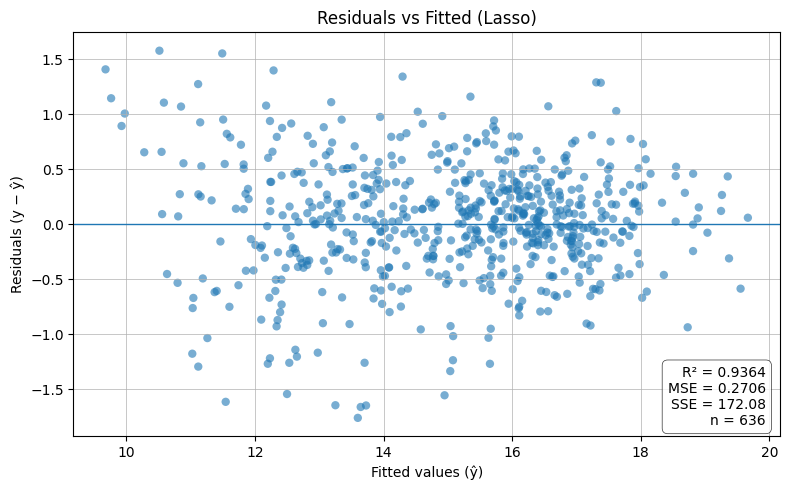

In [ ]:
r2 = r2_score(y_test, y_pred)
resid = y_test - y_pred
sse = float(np.sum(resid**2))
mse = float(sse / len(y_test))

# Residuals vs fitted: quick visual check for nonlinearity, heteroscedasticity, and outliers
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, resid, alpha=0.6, edgecolor="none")
plt.axhline(0, linewidth=1)                 # zero line for reference
plt.xlabel("Fitted values (ŷ)")
plt.ylabel("Residuals (y − ŷ)")
plt.title("Residuals vs Fitted (Lasso)")
plt.grid(True, linewidth=0.5)

# Stats box: test-set metrics for context
text = f"R² = {r2:.4f}\nMSE = {mse:.4f}\nSSE = {sse:.2f}\nn = {len(y_test)}"
plt.gca().text(
    0.98, 0.02, text,
    transform=plt.gca().transAxes,
    ha="right", va="bottom",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8, linewidth=0.5)
)

plt.tight_layout()
plt.show()

Make another residual plot...

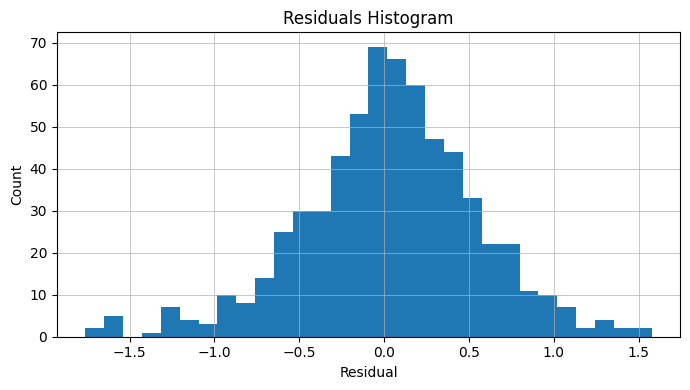

In [12]:
plt.figure(figsize=(7, 4))
plt.hist(resid, bins=30)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residuals Histogram")
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.show()

BASELINE mean        : R2=-0.0005  SSE=3016.0919  MSE=4.7423  n=636
LR[SQFT_log1p]        : R2=0.8209  SSE=539.8148  MSE=0.8488  n=636  (coef=1.0556, intercept=3.4813)
Lasso (final pipeline): R2=0.9293  SSE=212.9853  MSE=0.3349  n=636
            model        R2          SSE       MSE     coef  intercept
0   baseline_mean -0.000549  3016.091939  4.742283      NaN        NaN
1  LR[SQFT_log1p]  0.820924   539.814836  0.848765  1.05556   3.481269
2     lasso_final  0.929345   212.985306  0.334883      NaN        NaN


# Learning curve (MAE) on training data

I plot a learning curve to see how error changes as I increase the number of training examples. I use **MAE** as the metric, repeated K-fold CV for stability, and only the training split (to keep the test set untouched). This helps diagnose whether the model is bias-limited (both curves high and close) or variance-limited (large gap between train and validation curves) and whether adding more data would help.

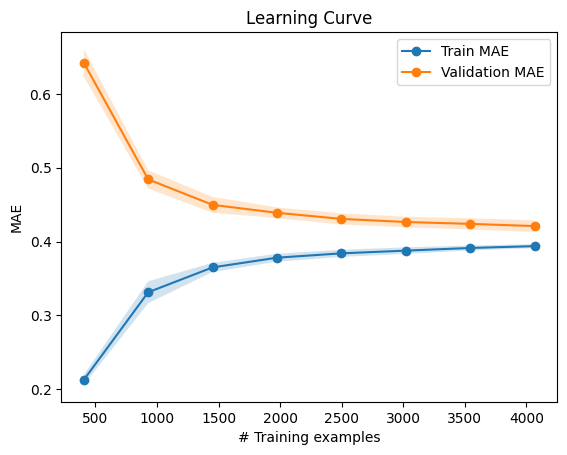

In [28]:
import numpy as np
from sklearn.model_selection import learning_curve, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error
import matplotlib.pyplot as plt

# Use only the training fold for learning_curve to avoid peeking at the test set
X_lc, y_lc = X_train, y_train

# Repeated K-fold for smoother estimates across training sizes
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# sklearn uses "higher-is-better"; negative MAE lets us plug MAE into that convention
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Sample 8 training sizes from 10% to 100%
train_sizes = np.linspace(0.1, 1.0, 8)

# learning_curve clones the estimator internally; passing a fitted pipeline is fine
sizes, train_scores, val_scores = learning_curve(
    estimator=final_lasso,
    X=X_lc, y=y_lc,
    train_sizes=train_sizes,
    cv=cv,
    scoring=scorer,          # or "neg_mean_absolute_error"
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# Convert from negative MAE to MAE for readability
train_mae = -train_scores
val_mae = -val_scores

# Plot mean ± 1 std for train/validation MAE
plt.figure()
plt.plot(sizes, train_mae.mean(axis=1), marker='o', label='Train MAE')
plt.fill_between(
    sizes,
    train_mae.mean(axis=1) - train_mae.std(axis=1),
    train_mae.mean(axis=1) + train_mae.std(axis=1),
    alpha=0.2
)
plt.plot(sizes, val_mae.mean(axis=1), marker='o', label='Validation MAE')
plt.fill_between(
    sizes,
    val_mae.mean(axis=1) - val_mae.std(axis=1),
    val_mae.mean(axis=1) + val_mae.std(axis=1),
    alpha=0.2
)
plt.xlabel('# Training examples')
plt.ylabel('MAE')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Validation-set check: baselines vs final pipeline

I compare three models on the validation split, holding training information fixed:
1) **Baseline mean** — predicts `mean(y_train)` to set a floor.
2) **One-feature LR** — `y ~ SQFT_log1p` fit on train, evaluated on val; a domain-reasonable bar.
3) **Final Lasso pipeline** — already fit on train; evaluated on val for apples-to-apples comparison.

This confirms that the tuned pipeline improves over simple heuristics on unseen data and helps diagnose when a complex model fails to clear a strong univariate baseline.

In [29]:
# Test values on the validation set.
from __future__ import annotations
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def evaluate_on_validation(
    X_train, y_train, X_val, y_val, final_lasso, feature="num__SQFT_log1p", decimals=4
):
    # --- helpers ---
    def _col2d(X, feat):
        # Return a single feature as 2D (n,1) for sklearn; supports DataFrame (by name) and ndarray (by index).
        import pandas as pd, numpy as np
        if isinstance(X, pd.DataFrame):
            if feat not in X.columns:
                raise KeyError(f"Column '{feat}' not found in X.")
            return X[[feat]].to_numpy()
        X = np.asarray(X)
        if isinstance(feat, (int, np.integer)):
            return X[:, [feat]]
        raise TypeError("For ndarray X, 'feature' must be an int index; for DataFrame X, a column name.")

    def _metrics(y_true, y_pred):
        # Compact metric helper to keep logic consistent across models.
        resid = y_true - y_pred
        sse = float(np.sum(resid**2))
        mse = float(sse / len(y_true))
        r2  = float(r2_score(y_true, y_pred))
        return r2, sse, mse

    # --- 1) Baseline mean (fit on train mean, eval on val) ---
    y_train = np.asarray(y_train).ravel()
    y_val   = np.asarray(y_val).ravel()
    mean_val = float(y_train.mean())
    yhat_mean = np.full_like(y_val, fill_value=mean_val, dtype=float)
    r2_mean, sse_mean, mse_mean = _metrics(y_val, yhat_mean)

    # --- 2) One-feature LinearRegression (fit on train, eval on val) ---
    Xtr_col = _col2d(X_train, feature)
    Xva_col = _col2d(X_val, feature)
    lr = LinearRegression().fit(Xtr_col, y_train)
    yhat_lr = lr.predict(Xva_col)
    r2_lr, sse_lr, mse_lr = _metrics(y_val, yhat_lr)

    # --- 3) Final Lasso pipeline (already fit on train), eval on val ---
    yhat_lasso = final_lasso.predict(X_val)
    r2_lasso, sse_lasso, mse_lasso = _metrics(y_val, yhat_lasso)

    # --- pretty print ---
    d = decimals
    print(f"BASELINE mean        : R2={r2_mean:.{d}f}  SSE={sse_mean:.{d}f}  MSE={mse_mean:.{d}f}  n={len(y_val)}")
    print(f"LR[{feature}]        : R2={r2_lr:.{d}f}  SSE={sse_lr:.{d}f}  MSE={mse_lr:.{d}f}  n={len(y_val)}  "
          f"(coef={lr.coef_[0]:.{d}f}, intercept={lr.intercept_:.{d}f})")
    print(f"Lasso (final pipeline): R2={r2_lasso:.{d}f}  SSE={sse_lasso:.{d}f}  MSE={mse_lasso:.{d}f}  n={len(y_val)}")

    # --- return a tidy summary ---
    summary = pd.DataFrame([
        {"model": "baseline_mean", "R2": r2_mean,  "SSE": sse_mean,  "MSE": mse_mean},
        {"model": f"LR[{feature}]", "R2": r2_lr,   "SSE": sse_lr,   "MSE": mse_lr,
         "coef": float(lr.coef_[0]), "intercept": float(lr.intercept_)},
        {"model": "lasso_final",    "R2": r2_lasso,"SSE": sse_lasso,"MSE": mse_lasso},
    ])
    return summary

# ---- Example call ----
summary_val = evaluate_on_validation(X_train, y_train, X_val, y_val, final_lasso, feature="SQFT_log1p")
print(summary_val)

BASELINE mean        : R2=-0.0005  SSE=3016.0919  MSE=4.7423  n=636
LR[SQFT_log1p]        : R2=0.8209  SSE=539.8148  MSE=0.8488  n=636  (coef=1.0556, intercept=3.4813)
Lasso (final pipeline): R2=0.9293  SSE=212.9853  MSE=0.3349  n=636
            model        R2          SSE       MSE     coef  intercept
0   baseline_mean -0.000549  3016.091939  4.742283      NaN        NaN
1  LR[SQFT_log1p]  0.820924   539.814836  0.848765  1.05556   3.481269
2     lasso_final  0.929345   212.985306  0.334883      NaN        NaN
